In [131]:
# Import useful libraries used in the notebook
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier

from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold

# Pull in the models we'll be building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC


# Visualization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Show plots inline 
%matplotlib inline

# Auto-reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
# Read in the dataset, look at the column names and NAs
credit_df = pd.read_csv('cs-training.csv')
credit_df.head()


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [138]:
# Need to do a bit of basic cleanup:

# Clean up the column names so it fits on one page width !
credit_df.columns = ['ID', 'target', 'revolving_pct', 'age', 
                     '30-59_past_due', 'debt_ratio', 
                     'monthly_income', 'lines', 
                     'gt_90_past_due', 'mortgages', 
                    '60-89_past_due', 'dependents']

# Replace missing values with 0 
# (quick-n-dirty ! Should try imputation or reserved value for trees)
credit_df[credit_df.isnull()] = 0

# Convert dependents to an integer
credit_df['dependents'] = credit_df['dependents'].astype('int64')

# Check how the data looks now
credit_df.head()

,ID,target,revolving_pct,age,30-59_past_due,debt_ratio,monthly_income,lines,gt_90_past_due,mortgages,60-89_past_due,dependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0


In [145]:
# Get some summary statistics from the dataframe
credit_df.describe()

,ID,target,revolving_pct,age,30-59_past_due,debt_ratio,monthly_income,lines,gt_90_past_due,mortgages,60-89_past_due,dependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,5.348139e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.315206e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,1.550000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,4.357500e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


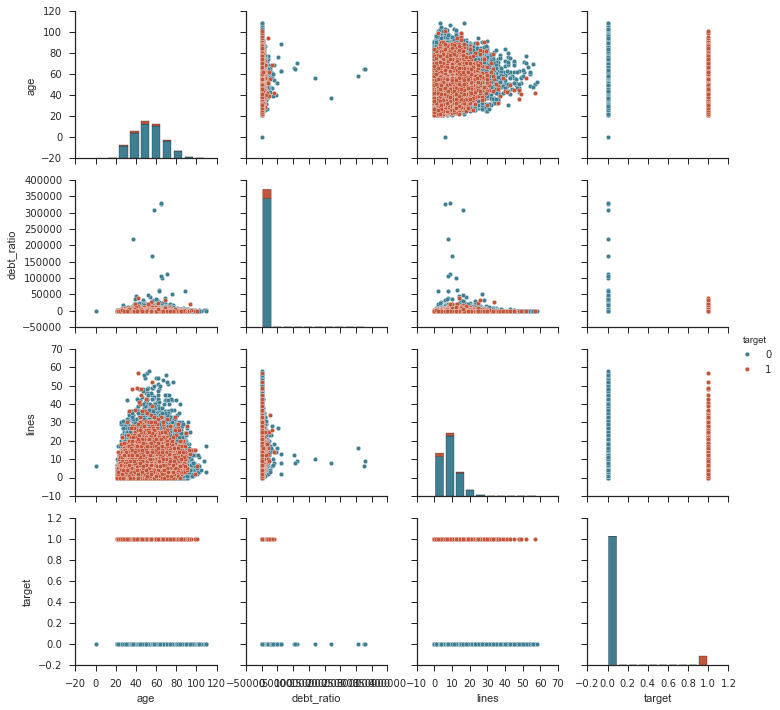

In [155]:
# Plot out the distributions to see what's going on, colour code by target
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(credit_df[['age', 'debt_ratio', 'lines', 'target']], 
                 hue='target', palette=sns.diverging_palette(220,20,n=2))


In [156]:
# Separate out the ID and target values from the dataset
y = credit_df['target']
id_val = credit_df['ID']
credit_df = credit_df.drop(['target'], axis=1)
credit_df = credit_df.drop(['ID'], axis=1)
X = credit_df


In [157]:
# T-SNE is hugely memory memory intensive ! Use random undersampling on majority class
x_min = X[y == 1]
x_maj = X[y == 0]

num_maj = X_maj.shape[0]
num_min = X_min.shape[0]
x_maj_idx = np.random.randint(num_maj, size=num_min)
x_maj_undersamp = x_maj.loc[:num_min,:]

# Combine minority and balanced majority examples
x_undersamp = np.vstack((x_min, x_maj_undersamp))
y_undersamp = np.vstack(np.array(([1] * x_min.shape[0]) + ([0] * x_maj_undersamp.shape[0])))
y_undersamp = np.squeeze(y_undersamp)


print X_min.shape
print X_maj.shape

# # # Do some data visualizations
# X_tsne = TSNE(n_components=2, perplexity=40, learning_rate=100, verbose=3).fit_transform(x_undersamp)
# X_pca = PCA().fit_transform(X)




(10026, 11)
(139974, 11)


/Users/tim/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 150000 but corresponding boolean dimension is 19411
/Users/tim/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 150000 but corresponding boolean dimension is 19411


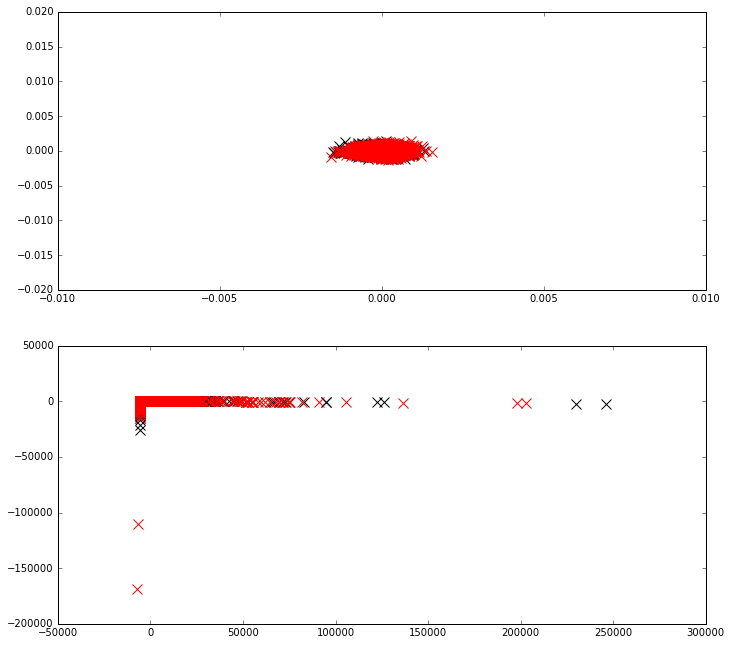

In [60]:
from pylab import rcParams

plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)
rcParams['figure.figsize'] = (10.0, 10.0)

plt.subplot(211)
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_undersamp, cmap = plt.get_cmap("Reds"))
plt.scatter(X_tsne[y_undersamp == 0][:, 0], X_tsne[y_undersamp == 0][:, 1], s=100, marker = "x", color="black")
plt.scatter(X_tsne[y_undersamp == 1][:, 0], X_tsne[y_undersamp == 1][:, 1], s=100, marker = "x", color="red")

plt.subplot(212)
plt.scatter(X_pca[y_undersamp == 0][:, 0], X_pca[y_undersamp == 0][:, 1], s=100, marker = "x", color="black")
plt.scatter(X_pca[y_undersamp == 1][:, 0], X_pca[y_undersamp == 1][:, 1], s=100, marker = "x", color="red")


# # print y[y==0].shape
# print X[y==0].shape
# print X[y==1].shape
# print X_pca.shape
# print X.shape
# print X_pca.shape
# print X_pca.shape

# print (y==0).shape

In [161]:
# Train a logistic regression model using the balanced class weights 

default_log_reg = LogisticRegression(class_weight=None)
balanced_log_reg = LogisticRegression(class_weight='balanced')

# Important to use a stratified K folds to make sure enough minority examples are used 
# in each fold
cv = StratifiedKFold(y, n_folds=5, shuffle=True)

default_log_reg_scores = cross_val_score(estimator=default_log_reg,
                        X=X, y=y, cv=cv, scoring='accuracy')
print 'Default logistic regression accuracy = {0:.2f}'.format(np.mean(default_log_reg_scores))

balanced_log_reg_scores = cross_val_score(estimator=balanced_log_reg,
                        X=X, y=y, cv=cv, scoring='accuracy')
print 'Balanced logistic regression accuracy = {0:.2f}'.format(np.mean(balanced_log_reg_scores))


default_log_reg_scores = cross_val_score(estimator=default_log_reg,
                        X=X, y=y, cv=cv, scoring='roc_auc')
print 'Default logistic regression ROC = {0:.2f}'.format(np.mean(default_log_reg_scores))


balanced_log_reg_scores = cross_val_score(estimator=balanced_log_reg,
                        X=X, y=y, cv=cv, scoring='roc_auc')
print 'Balanced logistic regression ROC = {0:.2f}'.format(np.mean(balanced_log_reg_scores))


Default logistic regression accuracy = 0.93
Balanced logistic regression accuracy = 0.77
Default logistic regression ROC = 0.70
Balanced logistic regression ROC = 0.79


In [112]:
# Train a linear SVM model using the balanced class weights 

balanced_lin_svm = LinearSVC(class_weight='balanced')
default_lin_svm = LinearSVC(class_weight=None)


default_lin_svm_scores = cross_val_score(estimator=default_lin_svm,
                        X=X, y=y, cv=cv,  scoring='roc_auc')

print default_lin_svm_scores

balanced_lin_svm_scores = cross_val_score(estimator=balanced_lin_svm,
                        X=X,
                        y=y,
                        cv=cv,
                        scoring='roc_auc')

print balanced_lin_svm_scores

[ 0.54081566  0.51150854  0.57781624  0.52616439  0.57874374]
[ 0.53356821  0.56140967  0.56746724  0.54433046  0.55604209]


In [106]:
# Train a Decision tree classifier

balanced_tree = DecisionTreeClassifier(class_weight='balanced')
default_tree = DecisionTreeClassifier(class_weight=None)


default_tree_scores = cross_val_score(estimator=default_tree,
                        X=X,
                        y=y,
                        cv=cv,
                        scoring='roc_auc')

print default_tree_scores

balanced_tree_scores = cross_val_score(estimator=balanced_tree,
                        X=X,
                        y=y,
                        cv=cv,
                        scoring='roc_auc')

print default_tree_scores

[ 0.61568857  0.61520018  0.61307211  0.61589486  0.60341762]
[ 0.61568857  0.61520018  0.61307211  0.61589486  0.60341762]
